In [2]:
import pickle
import os

In [3]:
with open('dic.pkl', 'rb') as f:
    dic = pickle.load(f)

In [4]:
lst = os.listdir('CompanyData')
orig = list(dic.keys())
chosen_list = []
delete_list = ['FALC', 'IDT', 'PRCP', 'BBOX', 'EVOL', 'CTS', 'FDC', 'NIHD', 'BRKS', 'KODK', 'OSPN', 'AEIS', 'LGL', 'QADA', 'PCMI']
for k in orig:
    if '{}output.xls'.format(k) not in lst or k in delete_list:
        del dic[k]
    else:
        chosen_list.append(k)
print(chosen_list)
print(len(chosen_list))
with open('chosen_list.txt', 'w') as f:
    for item in chosen_list:
        f.write("%s\n" % item)
with open('dic.pkl', 'wb') as f:
    pickle.dump(dic, f)

['INVE', 'PEGA', 'CASS', 'COHU', 'BDR', 'HMNY', 'BELFB', 'CDNS', 'KLAC', 'CY', 'XLNX', 'ZOOM', 'TACT', 'WGNR', 'NVDA', 'CMTL', 'AXE', 'TTWO', 'IT', 'INTC', 'ANEN', 'AMSWA', 'SYMC', 'AMKR', 'SPDC', 'CSCO', 'TLAB', 'SHEN', 'XRX', 'BHE', 'INTT', 'INAP', 'FTR', 'CRAY', 'SMIT', 'GVP', 'OLED', 'CYBE', 'MTSC', 'MCHP', 'ESCC', 'CTL', 'APH', 'LFUS', 'RMTR', 'VSAT', 'LSCC', 'ON', 'TDS', 'PAR', 'AAPL', 'PAYX', 'AXTI', 'EGOV', 'MMS', 'CELL', 'INTU', 'MSI', 'TRT', 'MSFT', 'QUIK', 'INOD', 'DGII', 'CSGS', 'DAIO', 'DDD', 'ASYS', 'WTT', 'EA', 'ITI', 'STCN', 'DIOD', 'NSYS', 'PLT', 'CYMI', 'MU', 'ZIXI', 'KVHI', 'NWK', 'DRCO', 'FICO', 'MSTR', 'IBM', 'CSPI', 'FSII', 'TYL', 'TXN', 'ADBE', 'HLIT', 'ALOT', 'CBB', 'PKE', 'SUPX', 'ADI', 'FARO', 'FFIV', 'EEFT', 'FLEX', 'VECO', 'MKSI', 'AWRE', 'CACI', 'FLIR', 'IAC', 'TSS', 'CIEN', 'TESS', 'MXWL', 'PRST', 'EBIX', 'IEC', 'VSH', 'ASUR', 'ZBRA', 'PCTI', 'TER', 'ANSS', 'TCX', 'EGHT', 'AMD', 'ACCL', 'WDC', 'OSIS', 'CREE', 'PFSW', 'ATEA', 'KLIC', 'NCR', 'CNXN', 'AVX', '

In [28]:
print(dic['AAPL']['sentiment_list'][0])

[0.012189404594467886, 0.005782153461478356, 0.01844038130957962, 0.005625879043600563, 0.003125488357555868, 0.0023441162681669013, 0.003438037193311455, 0.004219409282700422]


In [5]:
n_of_comp = len(chosen_list)

In [14]:
import numpy as np
def get_data(st, ed):
    X, Y = [], []
    companies = list(dic.keys())
    for comp in companies[st : ed]:
        for i in range(len(dic[comp]['sentiment_list']) - 1):
            X.append(dic[comp]['sentiment_list'][i])
            Y.append([dic[comp]['return_rate'][i]])
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [73]:
from sklearn.linear_model import Ridge, LinearRegression
def train_linear_regression(X, Y, Xall, Yall):
    X = (X - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
    clf = Ridge(alpha = 0.1)
    clf.fit(X, Y)
    #print('training:')
    #print('L2 error:\t', np.sum((clf.predict(X) - Y) ** 2) / Y.shape[0])
    #print('score:\t', clf.score(X, Y))
    #print('validation:')
    #print('L2 error:\t', np.sum((clf.predict(Xval) - Yval) ** 2) / Yval.shape[0])
    #print('score:\t', clf.score(Xval, Yval))
    r = np.corrcoef(clf.predict(X).reshape(-1), Y.reshape(-1))
    rall = np.corrcoef(clf.predict(Xall).reshape(-1), Yall.reshape(-1))
    #print('\nCorrelated Coefficient:\n', r[0][1], rall[0][1])
    pred = []
    lenx = Xall.shape[0]
    for i in range(n_of_comp):
        #Xind = Xall[lenx //  n_of_comp * i: lenx // n_of_comp * (i + 1)]
        Xind = (Xall[lenx //  n_of_comp * i: lenx // n_of_comp * (i + 1)] - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
        pred.append(clf.predict(Xind).reshape(-1))
    return clf.coef_, np.array(pred)

In [10]:
import numpy as np
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
def train_dnn(X, Y, Xall, Yall):
    X = (X - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    model = Sequential()
    model.add(Dense(128, input_shape = (X.shape[1], 1)))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'sigmoid'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = Adam(), metrics = [])
    model.fit(X, Y, batch_size = 32, epochs = 20)
    pred = []
    for i in range(n_of_comp):
        Xind = (Xall[lenx //  n_of_comp * i: lenx // n_of_comp * (i + 1)] - np.mean(Xall, axis = 0)) / np.std(Xall, axis = 0)
        tmp = model.predict(Xind.reshape((Xind.shape[0], Xind.shape[1], 1))).reshape(-1)
        pred.append(tmp)
    return np.array(pred)

In [74]:
Xall, Yall = get_data(0, n_of_comp)
lenx = Xall.shape[0]
K = 15
pred = np.zeros((n_of_comp, 29))
coef = np.zeros((1, 8))
for i in range(K):
    X, Y = get_data(n_of_comp // K * i, n_of_comp // K * (i + 1))
    c, p = train_linear_regression(X, Y, Xall, Yall)
    pred += p
    coef += c
pred /= K
coef /= K
r = [np.corrcoef(pred[i], Yall[lenx // n_of_comp * i: lenx // n_of_comp * (i + 1)].reshape(-1))[0][1] for i in range(n_of_comp)]
companies = list(dic.keys())
rank = [(r[i], companies[i]) for i in range(n_of_comp)]
rank = sorted(rank, reverse = True)
print(np.mean(np.array(r), axis = None))
rank

0.06422792883126262


[(0.5703689625500235, 'DRCO'),
 (0.5215544207524647, 'CTSH'),
 (0.47600184544228014, 'CY'),
 (0.47534822741616733, 'AMD'),
 (0.451280922917782, 'KVHI'),
 (0.40110584731868815, 'ANEN'),
 (0.4010646840316676, 'FTR'),
 (0.3888754899605384, 'MSFT'),
 (0.3769420175365108, 'RMTR'),
 (0.3632997021167672, 'AMKR'),
 (0.3621568807144643, 'CASS'),
 (0.34497823245834575, 'EEFT'),
 (0.33545083854888863, 'SUPX'),
 (0.33521908336132644, 'INTU'),
 (0.33384330598928685, 'MTSC'),
 (0.3187883947511041, 'CSCO'),
 (0.31787964812563246, 'TESS'),
 (0.30859578121368236, 'TER'),
 (0.2958201671346227, 'PAR'),
 (0.2877628658698768, 'CSGS'),
 (0.28710962570399584, 'IEC'),
 (0.2846180019350382, 'HLIT'),
 (0.2771070689549062, 'IBM'),
 (0.27496401108710106, 'ALOT'),
 (0.26290304192487546, 'MSTR'),
 (0.25607007427450995, 'INVE'),
 (0.24627149740163176, 'CELL'),
 (0.24201580929216907, 'EGOV'),
 (0.23901793731654752, 'IAC'),
 (0.236704359036741, 'ZIXI'),
 (0.23249129470791813, 'AXTI'),
 (0.22855471867021948, 'TDS'),
 (

(29,) (29,)
[ 0.00350502  0.00626423  0.00229886  0.00411485  0.0025358   0.00648556
  0.00063377 -0.00304608  0.00097146  0.00674944 -0.00044346 -0.00025961
  0.0007931  -0.00044673  0.00021591  0.00042771 -0.00061471 -0.00106058
 -0.00260742 -0.00163162  0.00149599 -0.00184949 -0.00367856 -0.00264184
 -0.00068736  0.00122591  0.00064905  0.00429821 -0.00108959]


<module 'matplotlib.pyplot' from '/Users/howard/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

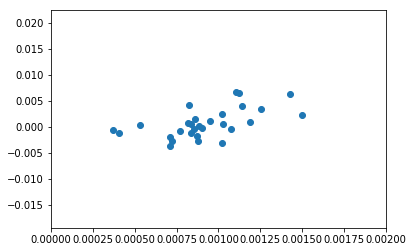

In [75]:
from matplotlib import pyplot as plt
idx = 79
X = pred[idx]
Y = Yall[29 * idx: 29 * (idx + 1)].reshape(-1)
print(X.shape, Y.shape)
print(Y)
plt.scatter(X, Y)
plt.xlim(0, 0.002)
plt

In [13]:
r = np.load('dnn_r.npy')
companies = list(dic.keys())
rank = [(r[i], companies[i]) for i in range(n_of_comp)]
rank = sorted(rank, reverse = True)
print(np.mean(r, axis = None))
rank

0.04731170128553646


[(0.512742234348051, 'FEIM'),
 (0.4649327262384743, 'TDS'),
 (0.42689711970418215, 'ITI'),
 (0.41175644825821633, 'ANEN'),
 (0.4082962240357552, 'FICO'),
 (0.35760322119445986, 'PLT'),
 (0.35004778167903416, 'XLNX'),
 (0.3491599150705975, 'IEC'),
 (0.3418026413108292, 'CACI'),
 (0.3312735845663457, 'BHE'),
 (0.3292303552390127, 'ON'),
 (0.3265506722882933, 'FLIR'),
 (0.3077839624724794, 'TRMB'),
 (0.3068480357798244, 'AAPL'),
 (0.302918373931888, 'CSGS'),
 (0.29743190899625727, 'DAIO'),
 (0.2876340309750617, 'MMS'),
 (0.273730696876465, 'CBB'),
 (0.2636983586535271, 'OLED'),
 (0.2579877089247843, 'TCX'),
 (0.2577999887574404, 'BELFB'),
 (0.2571000544861236, 'ALOT'),
 (0.2569972157411634, 'AXE'),
 (0.2500686343635304, 'TYL'),
 (0.2475504618442468, 'PAR'),
 (0.243059429149987, 'ZIXI'),
 (0.24145427373105144, 'CSCO'),
 (0.22860297565141302, 'VIAV'),
 (0.22697214796434173, 'COHU'),
 (0.2267246181440668, 'NVDA'),
 (0.2255260343575215, 'SMIT'),
 (0.2206054475487681, 'ASYS'),
 (0.214944209154

In [38]:
r = np.load('rnn_r.npy')
companies = list(dic.keys())
rank = [(r[i], companies[i]) for i in range(n_of_comp)]
rank = sorted(rank, reverse = True)
print(np.mean(r, axis = None))
rank

0.07412278504788151


[(0.6665981656897768, 'NWK'),
 (0.4902733955604108, 'EBIX'),
 (0.4675952935976823, 'CREE'),
 (0.43021020875577304, 'CYMI'),
 (0.4178374964037835, 'ANSS'),
 (0.41561210378096597, 'DRCO'),
 (0.3975453831724715, 'PEGA'),
 (0.33856273688662036, 'EA'),
 (0.3326920942310593, 'CMTL'),
 (0.30671692332129197, 'ATNI'),
 (0.302248438038557, 'FTR'),
 (0.283842004658443, 'SUPX'),
 (0.2784035320979778, 'PFSW'),
 (0.27108793445226137, 'OSIS'),
 (0.26289583839961267, 'FSII'),
 (0.2609967160603738, 'ASUR'),
 (0.2608777291855023, 'EGHT'),
 (0.2580989030325163, 'WTT'),
 (0.2537896537637873, 'CSPI'),
 (0.2501349281309258, 'VECO'),
 (0.24942694657452325, 'PLT'),
 (0.24732297035313167, 'NSYS'),
 (0.23796684267320908, 'TYL'),
 (0.23668297283350112, 'TER'),
 (0.233097861871434, 'BELFB'),
 (0.22745550634782707, 'VSAT'),
 (0.22702175874888403, 'TCX'),
 (0.22358401954677679, 'ACCL'),
 (0.22211458714608046, 'AAPL'),
 (0.2198914470986128, 'TACT'),
 (0.2165233891921308, 'FEIM'),
 (0.2132208695505838, 'FLEX'),
 (0.2

In [51]:
for idx, i in enumerate(dic):
    if i == 'DRCO':
        print(idx)
        break

79


(29,) (29,)
[ 0.0107893  -0.01172047  0.00700634  0.01058928 -0.02134031  0.00852961
  0.00500352 -0.00238713 -0.00194615  0.00880383 -0.00393718  0.00633849
  0.00151019 -0.00161518 -0.00115697  0.00176677  0.00103668  0.00132023
 -0.00050814  0.00211048  0.0021213   0.00234034  0.00019836  0.00386055
  0.00420702  0.00364783 -0.00079909  0.00597888  0.00271786]


<module 'matplotlib.pyplot' from '/Users/howard/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

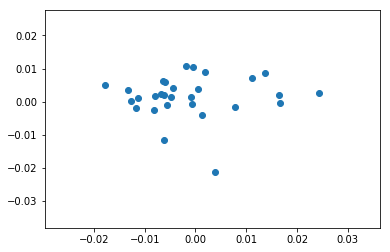

In [48]:
from matplotlib import pyplot as plt
idx = 109
X = np.load('rnn_pred.npy')
X = X[idx]
Xall, Yall = get_data(0, n_of_comp)
Y = Yall[29 * idx: 29 * (idx + 1)].reshape(-1)
print(X.shape, Y.shape)
print(Y)
plt.scatter(X, Y)
plt